# Covid-19 classifier

## Table of Contents
* [Data Visualization](#Data-Visualization)
    * [Sample Images](#Sample-Images)
    * [Class Frequencies](#Class-Frequencies)
* [Neural Nets](#Neural-Nets)
    * [Relu](#Relu)
    * [Tanh](#Tanh)
    * [Normalized](#Normalized)
    * [Optimizers](#Optimizers)
        * [Momentum](#Momentum)
            * [Momentum = 0.5](#Momentum-=-0.5)
            * [Momentum = 0.9](#Momentum-=-0.9)
            * [Momentum = 0.99](#Momentum-=-0.99)
        * [Adam](#Adam)
    * [Epochs](#Epochs)
    * [Losses](#Losses)
        * [MSE](#MSE)
    * [Regularization](#Regularization)
        * [L2](#L2)
        * [Dropout](#Drop-out)

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
! cp "/content/drive/MyDrive/University/Term 5/AI/xray.zip" .

In [6]:
from tensorflow.keras import *
import matplotlib.pyplot as plt
import numpy as np

## Data Visualization

In [2]:
dataGenerator = preprocessing.image.ImageDataGenerator()
dataTrain = dataGenerator.flow_from_directory(
    "Data/train",
    target_size=(80,80),
    color_mode="grayscale",
    batch_size=32,
    shuffle=False
)
dataTest = dataGenerator.flow_from_directory(
    "Data/test",
    target_size=(80,80),
    color_mode="grayscale",
    batch_size=32,
    shuffle=False
)

Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


### Sample Images

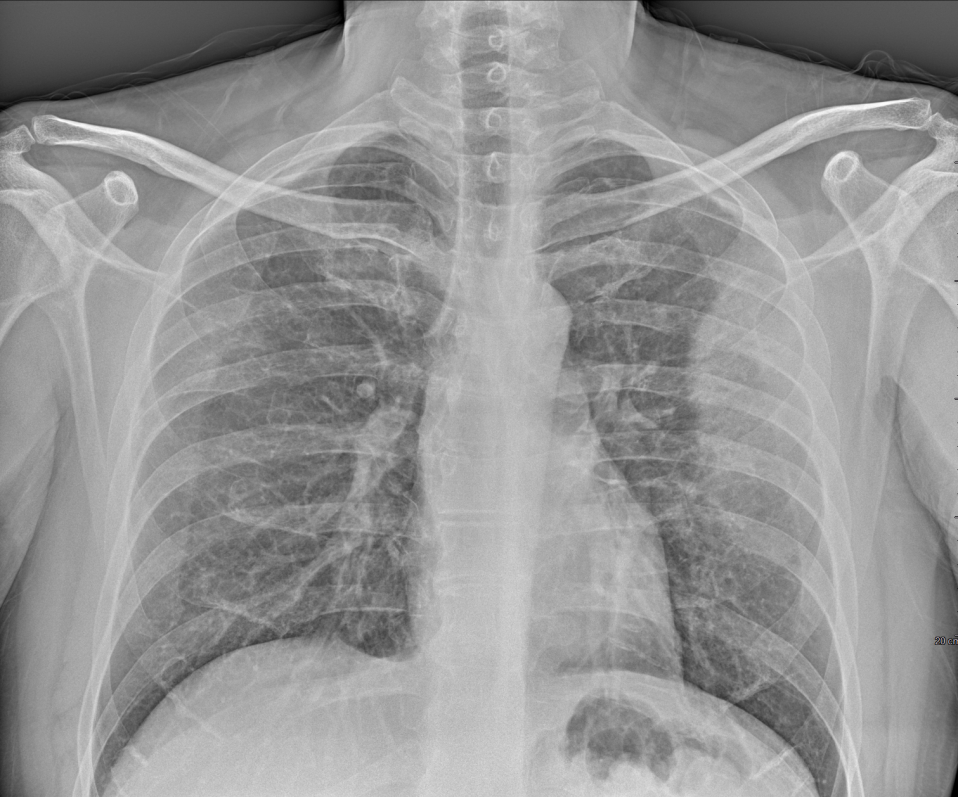

Covid


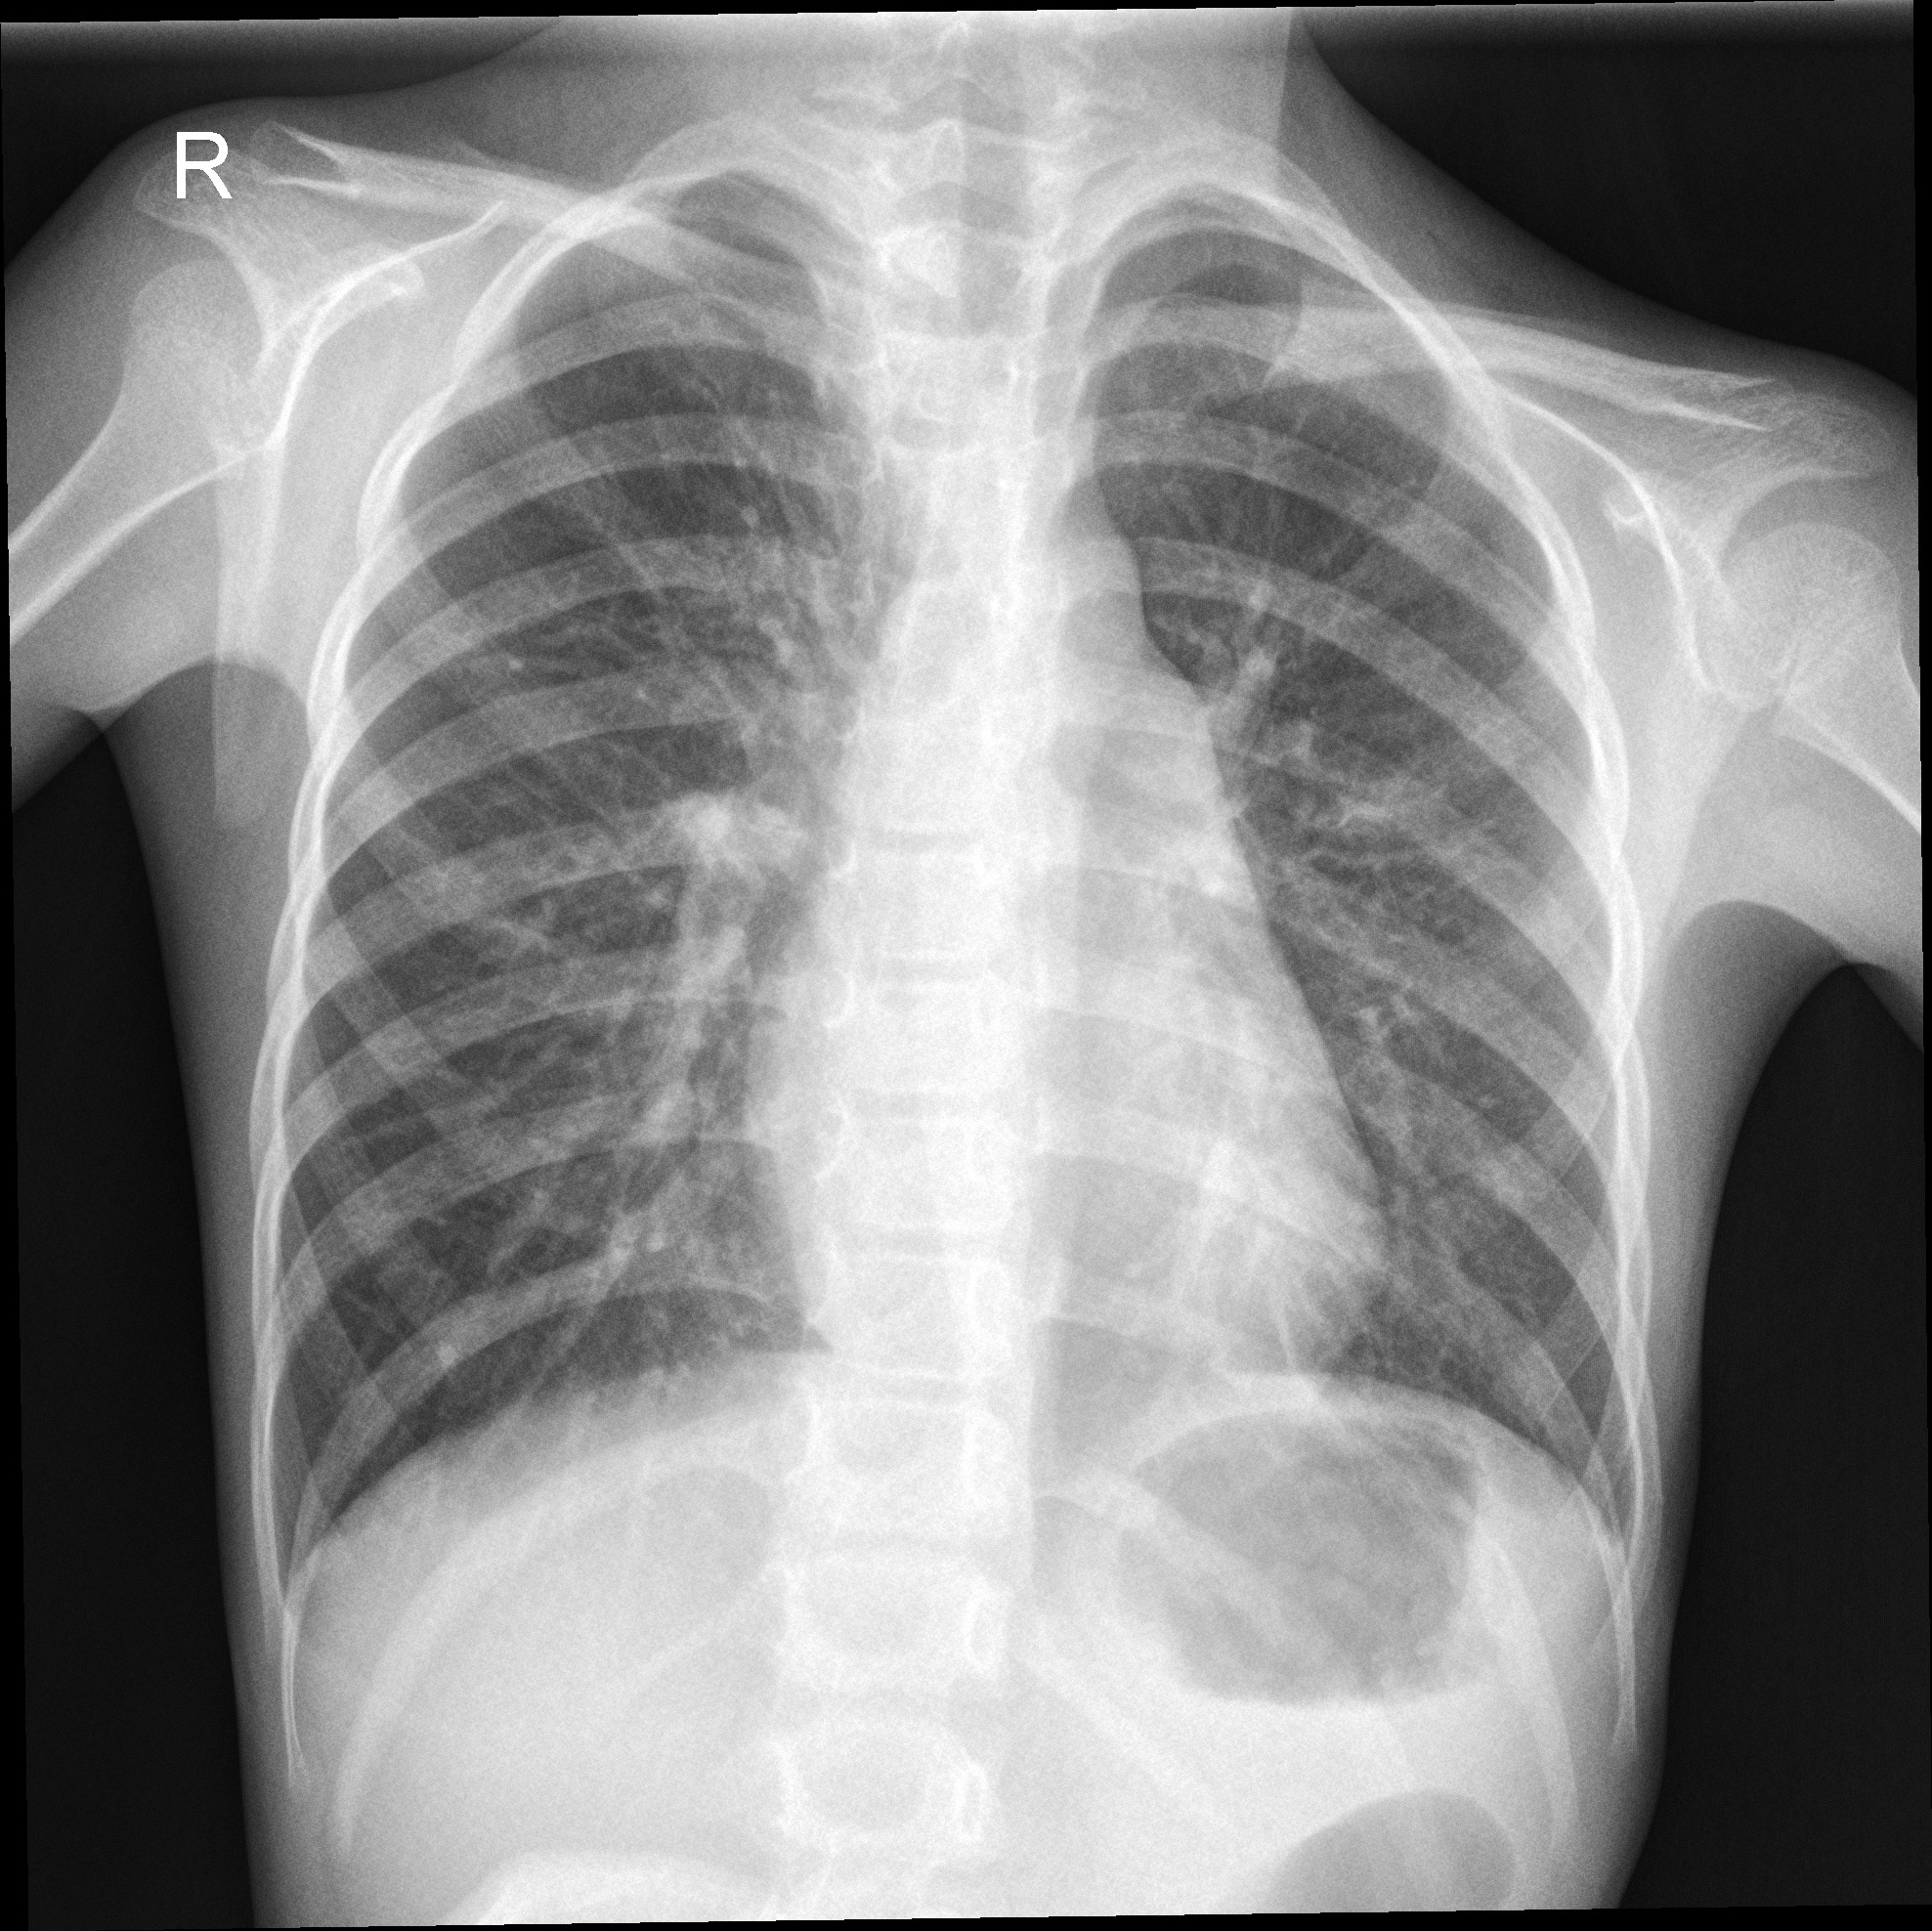

Normal


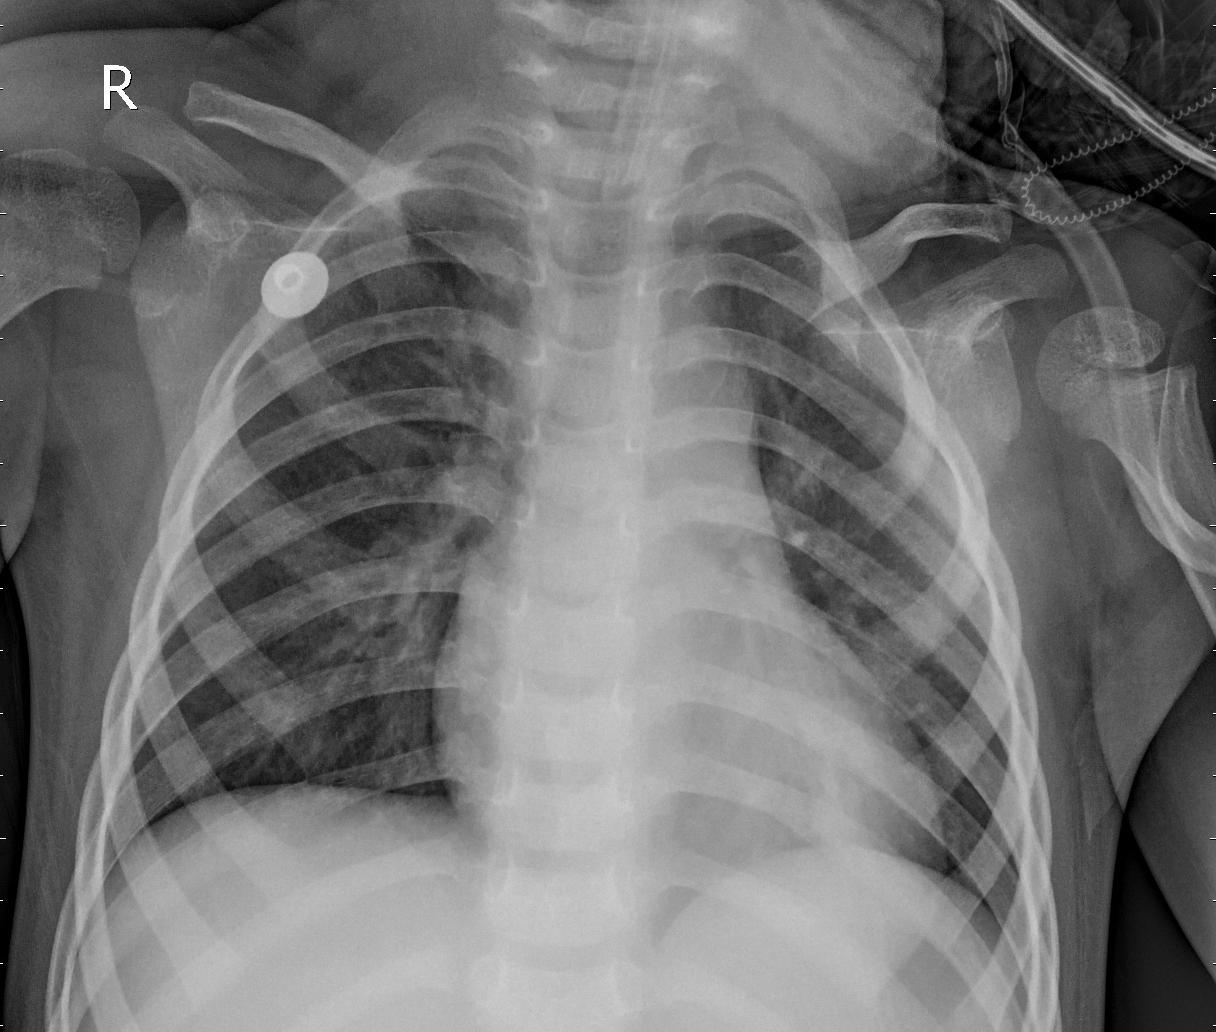

Pneumonia


In [3]:
covid = "/content/Data/train/COVID19/COVID19(106).jpg"
normal = "/content/Data/train/NORMAL/NORMAL(1009).jpg"
pneumonia = "/content/Data/train/PNEUMONIA/PNEUMONIA(1005).jpg"
from IPython.display import Image, display
display(Image(filename=covid, width=200, height=200))
print("Covid")
display(Image(filename=normal, width=200, height=200))
print("Normal")
display(Image(filename=pneumonia, width=200, height=200))
print("Pneumonia")

### Class Frequencies

In [ ]:
from collections import Counter
labels = ["Covid", "Normal", "Pneumonia"]
labels_count_train = Counter(dataTrain.classes)
labels_count_test = Counter(dataTest.classes)
labels_count_train[labels[0]] = labels_count_train[0]
labels_count_train[labels[1]] = labels_count_train[1]
labels_count_train[labels[2]] = labels_count_train[2]
del labels_count_train[0], labels_count_train[1], labels_count_train[2]
labels_count_test[labels[0]] = labels_count_test[0]
labels_count_test[labels[1]] = labels_count_test[1]
labels_count_test[labels[2]] = labels_count_test[2]
del labels_count_test[0], labels_count_test[1], labels_count_test[2]

<BarContainer object of 3 artists>

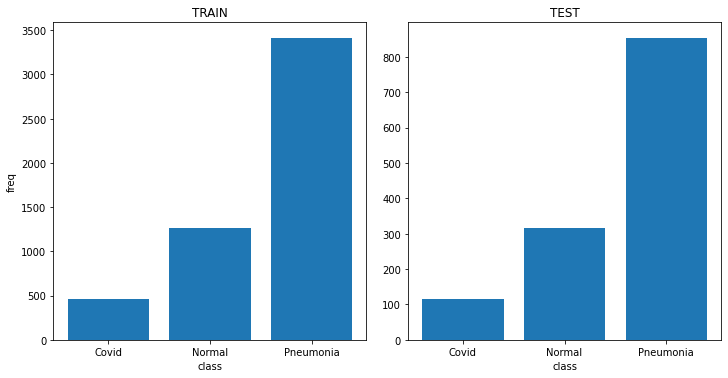

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
plt.tight_layout()
ax1.set_title("TRAIN")
ax1.set_xlabel("class")
ax1.set_ylabel("freq")
ax1.bar(labels_count_train.keys(), labels_count_train.values())
ax2.set_title("TEST")
ax2.set_xlabel("class")
ax2.bar(labels_count_test.keys(), labels_count_test.values())

## Neural Nets

In [13]:
from sklearn.metrics import classification_report
def report(model, train, test):
  pred_one_hot_train = model.predict(train)
  pred_val_train = np.argmax(pred_one_hot_train, axis=1)
  print("TRAIN")
  print(classification_report(train.labels, pred_val_train, target_names=["Covid", "Normal", "Pneumonia"]))
  pred_one_hot_test = model.predict(test)
  pred_val_test = np.argmax(pred_one_hot_test, axis=1)
  print("TEST")
  print(classification_report(test.labels, pred_val_test, target_names=["Covid", "Normal", "Pneumonia"]))
def report_plt(hist):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
  plt.tight_layout()
  ax1.set_title("Accuracy")
  ax1.set_ylabel("accuracy")
  ax1.set_xlabel("epoch")
  ax1.plot(hist.history['accuracy'], label="train")
  ax1.plot(hist.history['val_accuracy'], label="test")
  ax1.legend()
  ax2.set_title("Loss")
  ax2.set_ylabel("loss")
  ax2.set_xlabel("epoch")
  ax2.plot(hist.history['loss'], label="train")
  ax2.plot(hist.history['val_loss'], label="test")
  ax2.legend()

### Relu

In this part we didn't normalize the inputs and as we can see below,  
Relu can goes as high as the input in the positive section.  
This causes __gradient explosion__, our neural network stops learning and the values become NaN.  
All in all this causes overflow and ruines our learning process.

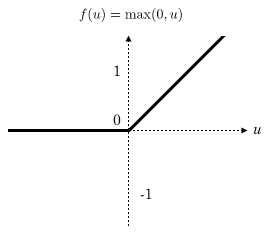

In [3]:
input = layers.Input(shape=(80,80,1))
out = layers.Flatten()(input)
out = layers.Dense(1024, activation=activations.relu)(out)
out = layers.Dense(1024, activation=activations.relu)(out)
out = layers.Dense(3, activation=activations.softmax)(out)
model = models.Model(inputs=input, outputs=out)
model.compile(optimizer=optimizers.SGD(learning_rate=0.01), loss=losses.categorical_crossentropy, metrics=["accuracy"])

In [4]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80, 80, 1)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 6400)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              6554624   
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 3075      
Total params: 7,607,299
Trainable params: 7,607,299
Non-trainable params: 0
_________________________________________________________________


Above we can observe a summary of the network and its layer shapes, params and layer types.  
For example in the third layer we have 6400 fully connected inputs from the last layer and also 1024 neurons in this layer.  
So it adds up to 6400 * 1024 + 1024 = __6554624__  
In the fourth layer:  
1024 * 1024 + 1024  = __1049600__  
In the last dense layer:  
1024 * 3 + 3 = __3075__  
The additional sum is caused by the bias term.

In [5]:
hist = model.fit(dataTrain, validation_data=dataTest, epochs=10)

Epoch 1/10
161/161 [==============================] - 155s 961ms/step - loss: nan - accuracy: 0.2269 - val_loss: nan - val_accuracy: 0.0901
Epoch 2/10
161/161 [==============================] - 154s 957ms/step - loss: nan - accuracy: 0.1053 - val_loss: nan - val_accuracy: 0.0901
Epoch 3/10
161/161 [==============================] - 152s 946ms/step - loss: nan - accuracy: 0.0802 - val_loss: nan - val_accuracy: 0.0901
Epoch 4/10
161/161 [==============================] - 153s 949ms/step - loss: nan - accuracy: 0.0814 - val_loss: nan - val_accuracy: 0.0901
Epoch 5/10
161/161 [==============================] - 154s 954ms/step - loss: nan - accuracy: 0.0769 - val_loss: nan - val_accuracy: 0.0901
Epoch 6/10
161/161 [==============================] - 155s 966ms/step - loss: nan - accuracy: 0.1091 - val_loss: nan - val_accuracy: 0.0901
Epoch 7/10
161/161 [==============================] - 156s 968ms/step - loss: nan - accuracy: 0.0728 - val_loss: nan - val_accuracy: 0.0901
Epoch 8/10
161/161 [

In [9]:
 report(model, dataTrain, dataTest)

TRAIN
              precision    recall  f1-score   support

       Covid       0.09      1.00      0.16       460
      Normal       0.00      0.00      0.00      1266
   Pneumonia       0.00      0.00      0.00      3418

    accuracy                           0.09      5144
   macro avg       0.03      0.33      0.05      5144
weighted avg       0.01      0.09      0.01      5144



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TEST
              precision    recall  f1-score   support

       Covid       0.09      1.00      0.17       116
      Normal       0.00      0.00      0.00       317
   Pneumonia       0.00      0.00      0.00       855

    accuracy                           0.09      1288
   macro avg       0.03      0.33      0.06      1288
weighted avg       0.01      0.09      0.01      1288



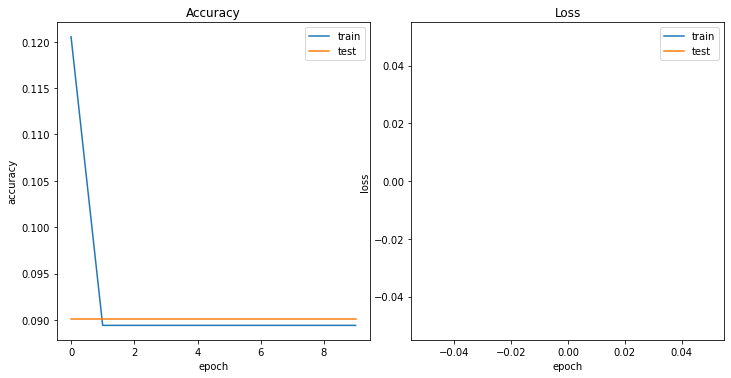

In [10]:
report_plt(hist)

### Tanh

As we can see in the training output, learning process stops after some epochs.  
This is because of a phenomena called __Gradient Vanishing__.  
As we can see in the figure below the deravative becomes zero for high or low values.  
So the gradients become smaller and the learning process stops.

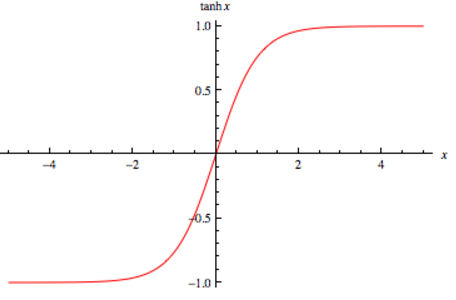

In [11]:
input = layers.Input(shape=(80,80,1))
out = layers.Flatten()(input)
out = layers.Dense(1024, activation=activations.tanh)(out)
out = layers.Dense(1024, activation=activations.tanh)(out)
out = layers.Dense(3, activation=activations.softmax)(out)
model = models.Model(inputs=input, outputs=out)
model.compile(optimizer=optimizers.SGD(learning_rate=0.01), loss=losses.categorical_crossentropy, metrics=["accuracy"])
hist = model.fit(dataTrain, validation_data=dataTest, epochs=10)

Epoch 1/10
161/161 [==============================] - 152s 943ms/step - loss: 2.8559 - accuracy: 0.5795 - val_loss: 1.4709 - val_accuracy: 0.6638
Epoch 2/10
161/161 [==============================] - 151s 940ms/step - loss: 1.2730 - accuracy: 0.5677 - val_loss: 1.2115 - val_accuracy: 0.6638
Epoch 3/10
161/161 [==============================] - 153s 945ms/step - loss: 1.2108 - accuracy: 0.5080 - val_loss: 0.9003 - val_accuracy: 0.6638
Epoch 4/10
161/161 [==============================] - 154s 957ms/step - loss: 0.9615 - accuracy: 0.6542 - val_loss: 0.8699 - val_accuracy: 0.6638
Epoch 5/10
161/161 [==============================] - 154s 960ms/step - loss: 1.0456 - accuracy: 0.5031 - val_loss: 0.8800 - val_accuracy: 0.6638
Epoch 6/10
161/161 [==============================] - 153s 954ms/step - loss: 0.7813 - accuracy: 0.6778 - val_loss: 1.0207 - val_accuracy: 0.6638
Epoch 7/10
161/161 [==============================] - 153s 952ms/step - loss: 1.0331 - accuracy: 0.5666 - val_loss: 0.8902 -

In [12]:
report(model, dataTrain, dataTest)

TRAIN
              precision    recall  f1-score   support

       Covid       0.00      0.00      0.00       460
      Normal       0.00      0.00      0.00      1266
   Pneumonia       0.66      1.00      0.80      3418

    accuracy                           0.66      5144
   macro avg       0.22      0.33      0.27      5144
weighted avg       0.44      0.66      0.53      5144



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TEST
              precision    recall  f1-score   support

       Covid       0.00      0.00      0.00       116
      Normal       0.00      0.00      0.00       317
   Pneumonia       0.66      1.00      0.80       855

    accuracy                           0.66      1288
   macro avg       0.22      0.33      0.27      1288
weighted avg       0.44      0.66      0.53      1288



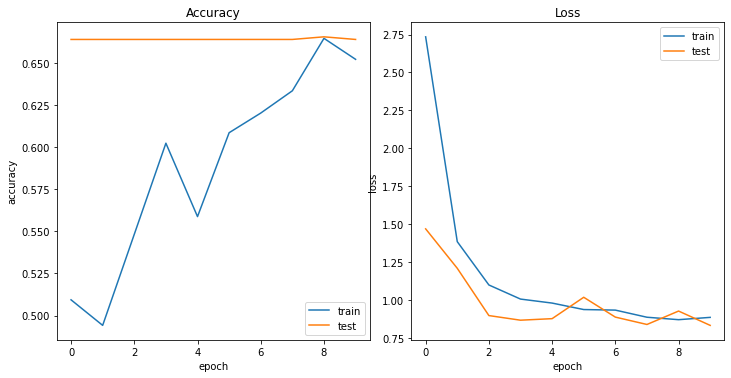

In [13]:
report_plt(hist)

As we talked above both of the models stop learning because of bad input/weights problem.  
Tanh does not grow big to overflow but as we saw earlier relu does.  
To prevent both the saturation problem and the overflow problem in the two earlier models, We can use __Normalizing.__  
Or we can change the method of weight initialization but normalizing seems more effective in the first place.

### Normalized

In [7]:
dataGenerator = preprocessing.image.ImageDataGenerator(rescale=1/255.0)
no_shuffle_dataTrain = dataGenerator.flow_from_directory(
    "Data/train",
    target_size=(80,80),
    color_mode="grayscale",
    batch_size=32,
    shuffle=False
)
dataTrain = dataGenerator.flow_from_directory(
    "Data/train",
    target_size=(80,80),
    color_mode="grayscale",
    batch_size=32
)
no_shuffle_dataTest = dataGenerator.flow_from_directory(
    "Data/test",
    target_size=(80,80),
    color_mode="grayscale",
    batch_size=32,
    shuffle=False
)
dataTest = dataGenerator.flow_from_directory(
    "Data/test",
    target_size=(80,80),
    color_mode="grayscale",
    batch_size=32
)

Found 5144 images belonging to 3 classes.
Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


In [15]:
input = layers.Input(shape=(80,80,1))
out = layers.Flatten()(input)
out = layers.Dense(1024, activation=activations.relu)(out)
out = layers.Dense(1024, activation=activations.relu)(out)
out = layers.Dense(3, activation=activations.softmax)(out)
model = models.Model(inputs=input, outputs=out)
model.compile(optimizer=optimizers.SGD(learning_rate=0.01), loss=losses.categorical_crossentropy, metrics=["accuracy"])
hist = model.fit(dataTrain, validation_data=dataTest, epochs=10)

Epoch 1/10
161/161 [==============================] - 153s 947ms/step - loss: 0.7083 - accuracy: 0.6968 - val_loss: 0.3095 - val_accuracy: 0.8866
Epoch 2/10
161/161 [==============================] - 153s 951ms/step - loss: 0.3979 - accuracy: 0.8405 - val_loss: 0.2714 - val_accuracy: 0.8944
Epoch 3/10
161/161 [==============================] - 154s 955ms/step - loss: 0.3442 - accuracy: 0.8740 - val_loss: 0.2705 - val_accuracy: 0.9022
Epoch 4/10
161/161 [==============================] - 154s 955ms/step - loss: 0.2959 - accuracy: 0.8904 - val_loss: 0.2093 - val_accuracy: 0.9193
Epoch 5/10
161/161 [==============================] - 153s 953ms/step - loss: 0.2899 - accuracy: 0.8907 - val_loss: 0.2006 - val_accuracy: 0.9239
Epoch 6/10
161/161 [==============================] - 154s 954ms/step - loss: 0.2559 - accuracy: 0.9042 - val_loss: 0.1984 - val_accuracy: 0.9216
Epoch 7/10
161/161 [==============================] - 154s 961ms/step - loss: 0.2425 - accuracy: 0.9135 - val_loss: 0.2363 -

In [16]:
report(model, no_shuffle_dataTrain, no_shuffle_dataTest)

TRAIN
              precision    recall  f1-score   support

       Covid       0.96      0.86      0.90       460
      Normal       0.89      0.89      0.89      1266
   Pneumonia       0.95      0.96      0.96      3418

    accuracy                           0.93      5144
   macro avg       0.93      0.90      0.92      5144
weighted avg       0.93      0.93      0.93      5144

TEST
              precision    recall  f1-score   support

       Covid       0.99      0.83      0.90       116
      Normal       0.89      0.91      0.90       317
   Pneumonia       0.95      0.97      0.96       855

    accuracy                           0.94      1288
   macro avg       0.95      0.90      0.92      1288
weighted avg       0.94      0.94      0.94      1288



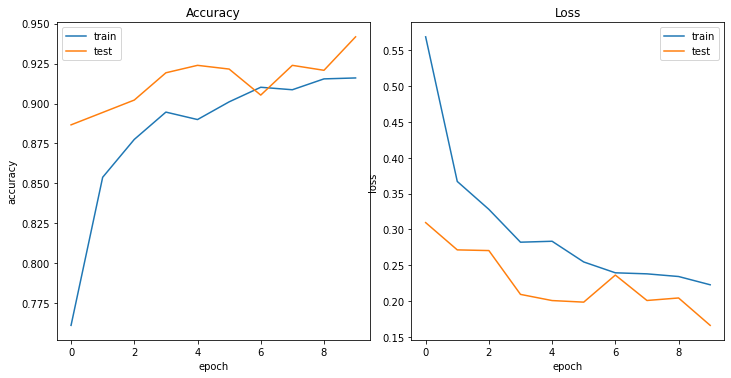

In [17]:
report_plt(hist)

In [18]:
input = layers.Input(shape=(80,80,1))
out = layers.Flatten()(input)
out = layers.Dense(1024, activation=activations.tanh)(out)
out = layers.Dense(1024, activation=activations.tanh)(out)
out = layers.Dense(3, activation=activations.softmax)(out)
model = models.Model(inputs=input, outputs=out)
model.compile(optimizer=optimizers.SGD(learning_rate=0.01), loss=losses.categorical_crossentropy, metrics=["accuracy"])
hist = model.fit(dataTrain, validation_data=dataTest, epochs=10)

Epoch 1/10
161/161 [==============================] - 156s 968ms/step - loss: 1.1240 - accuracy: 0.6588 - val_loss: 0.3615 - val_accuracy: 0.8362
Epoch 2/10
161/161 [==============================] - 157s 974ms/step - loss: 0.4690 - accuracy: 0.8044 - val_loss: 0.3593 - val_accuracy: 0.8502
Epoch 3/10
161/161 [==============================] - 156s 972ms/step - loss: 0.3576 - accuracy: 0.8616 - val_loss: 0.1998 - val_accuracy: 0.9262
Epoch 4/10
161/161 [==============================] - 155s 961ms/step - loss: 0.3115 - accuracy: 0.8819 - val_loss: 0.1982 - val_accuracy: 0.9239
Epoch 5/10
161/161 [==============================] - 156s 970ms/step - loss: 0.2715 - accuracy: 0.8963 - val_loss: 0.1964 - val_accuracy: 0.9301
Epoch 6/10
161/161 [==============================] - 156s 968ms/step - loss: 0.2826 - accuracy: 0.8906 - val_loss: 0.2825 - val_accuracy: 0.8835
Epoch 7/10
161/161 [==============================] - 151s 940ms/step - loss: 0.2544 - accuracy: 0.9015 - val_loss: 0.1778 -

In [19]:
report(model, no_shuffle_dataTrain, no_shuffle_dataTest)

TRAIN
              precision    recall  f1-score   support

       Covid       0.93      0.88      0.91       460
      Normal       0.91      0.84      0.87      1266
   Pneumonia       0.93      0.97      0.95      3418

    accuracy                           0.93      5144
   macro avg       0.92      0.90      0.91      5144
weighted avg       0.93      0.93      0.93      5144

TEST
              precision    recall  f1-score   support

       Covid       0.94      0.91      0.92       116
      Normal       0.93      0.89      0.91       317
   Pneumonia       0.95      0.97      0.96       855

    accuracy                           0.94      1288
   macro avg       0.94      0.92      0.93      1288
weighted avg       0.94      0.94      0.94      1288



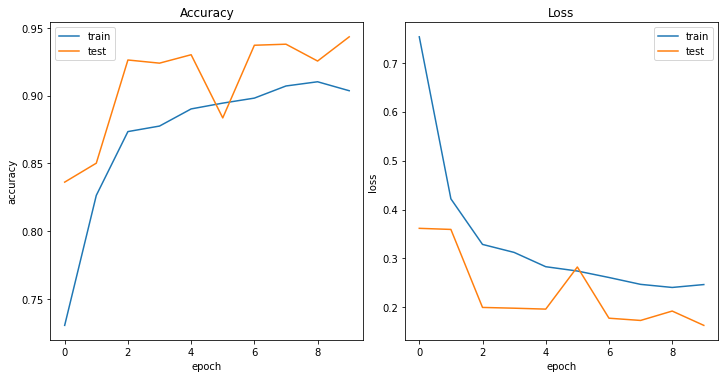

In [20]:
report_plt(hist)

### Optimizers

#### Momentum
Momentum is known to be effective for better convergance in training of neural networks.  
It adds another term:  
v = mu * v - learning_rate * dx  
x += v
The momentum term gets bigger for situations where the gradient points in the same direction,  
It can help us converge faster.
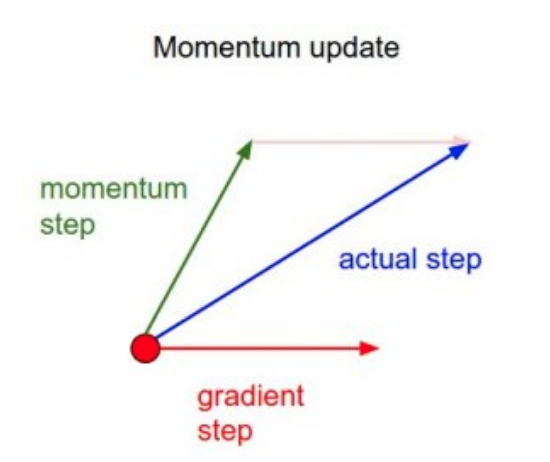  
Source: __Cs231n stanford university__

##### Momentum = 0.5

In [21]:
input = layers.Input(shape=(80,80,1))
out = layers.Flatten()(input)
out = layers.Dense(1024, activation=activations.relu)(out)
out = layers.Dense(1024, activation=activations.relu)(out)
out = layers.Dense(3, activation=activations.softmax)(out)
model = models.Model(inputs=input, outputs=out)
model.compile(optimizer=optimizers.SGD(learning_rate=0.01, momentum=0.5), loss=losses.categorical_crossentropy, metrics=["accuracy"])
hist = model.fit(dataTrain, validation_data=dataTest, epochs=10)

Epoch 1/10
161/161 [==============================] - 149s 923ms/step - loss: 0.6451 - accuracy: 0.7354 - val_loss: 0.3041 - val_accuracy: 0.8649
Epoch 2/10
161/161 [==============================] - 149s 929ms/step - loss: 0.3273 - accuracy: 0.8698 - val_loss: 0.2080 - val_accuracy: 0.9200
Epoch 3/10
161/161 [==============================] - 151s 937ms/step - loss: 0.2787 - accuracy: 0.8956 - val_loss: 0.1987 - val_accuracy: 0.9301
Epoch 4/10
161/161 [==============================] - 152s 946ms/step - loss: 0.2513 - accuracy: 0.9067 - val_loss: 0.2111 - val_accuracy: 0.9161
Epoch 5/10
161/161 [==============================] - 154s 957ms/step - loss: 0.2564 - accuracy: 0.9046 - val_loss: 0.1994 - val_accuracy: 0.9239
Epoch 6/10
161/161 [==============================] - 154s 956ms/step - loss: 0.2211 - accuracy: 0.9115 - val_loss: 0.1817 - val_accuracy: 0.9340
Epoch 7/10
161/161 [==============================] - 152s 946ms/step - loss: 0.2411 - accuracy: 0.9081 - val_loss: 0.4301 -

In [22]:
report(model, no_shuffle_dataTrain, no_shuffle_dataTest)

TRAIN
              precision    recall  f1-score   support

       Covid       0.90      0.93      0.92       460
      Normal       0.96      0.79      0.86      1266
   Pneumonia       0.92      0.98      0.95      3418

    accuracy                           0.93      5144
   macro avg       0.93      0.90      0.91      5144
weighted avg       0.93      0.93      0.93      5144

TEST
              precision    recall  f1-score   support

       Covid       0.92      0.96      0.94       116
      Normal       0.95      0.83      0.89       317
   Pneumonia       0.94      0.98      0.96       855

    accuracy                           0.94      1288
   macro avg       0.94      0.92      0.93      1288
weighted avg       0.94      0.94      0.94      1288



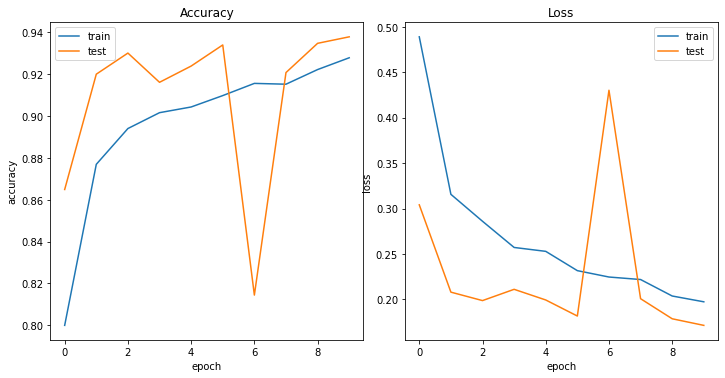

In [23]:
report_plt(hist)

##### Momentum = 0.9

In [24]:
input = layers.Input(shape=(80,80,1))
out = layers.Flatten()(input)
out = layers.Dense(1024, activation=activations.relu)(out)
out = layers.Dense(1024, activation=activations.relu)(out)
out = layers.Dense(3, activation=activations.softmax)(out)
model = models.Model(inputs=input, outputs=out)
model.compile(optimizer=optimizers.SGD(learning_rate=0.01, momentum=0.9), loss=losses.categorical_crossentropy, metrics=["accuracy"])
hist = model.fit(dataTrain, validation_data=dataTest, epochs=10)

Epoch 1/10
161/161 [==============================] - 154s 957ms/step - loss: 0.7339 - accuracy: 0.7009 - val_loss: 0.3065 - val_accuracy: 0.9037
Epoch 2/10
161/161 [==============================] - 153s 950ms/step - loss: 0.3708 - accuracy: 0.8527 - val_loss: 0.2215 - val_accuracy: 0.9216
Epoch 3/10
161/161 [==============================] - 154s 959ms/step - loss: 0.2846 - accuracy: 0.8932 - val_loss: 0.2152 - val_accuracy: 0.9146
Epoch 4/10
161/161 [==============================] - 155s 965ms/step - loss: 0.2721 - accuracy: 0.8958 - val_loss: 0.2874 - val_accuracy: 0.8890
Epoch 5/10
161/161 [==============================] - 155s 965ms/step - loss: 0.2394 - accuracy: 0.8983 - val_loss: 0.2237 - val_accuracy: 0.9115
Epoch 6/10
161/161 [==============================] - 155s 964ms/step - loss: 0.2624 - accuracy: 0.8960 - val_loss: 0.1982 - val_accuracy: 0.9216
Epoch 7/10
161/161 [==============================] - 154s 957ms/step - loss: 0.2365 - accuracy: 0.9130 - val_loss: 0.1796 -

In [25]:
report(model, no_shuffle_dataTrain, no_shuffle_dataTest)

TRAIN
              precision    recall  f1-score   support

       Covid       0.97      0.78      0.87       460
      Normal       0.97      0.66      0.79      1266
   Pneumonia       0.87      0.99      0.93      3418

    accuracy                           0.89      5144
   macro avg       0.94      0.81      0.86      5144
weighted avg       0.90      0.89      0.89      5144

TEST
              precision    recall  f1-score   support

       Covid       1.00      0.76      0.86       116
      Normal       0.95      0.71      0.81       317
   Pneumonia       0.88      0.99      0.93       855

    accuracy                           0.90      1288
   macro avg       0.94      0.82      0.87      1288
weighted avg       0.91      0.90      0.90      1288



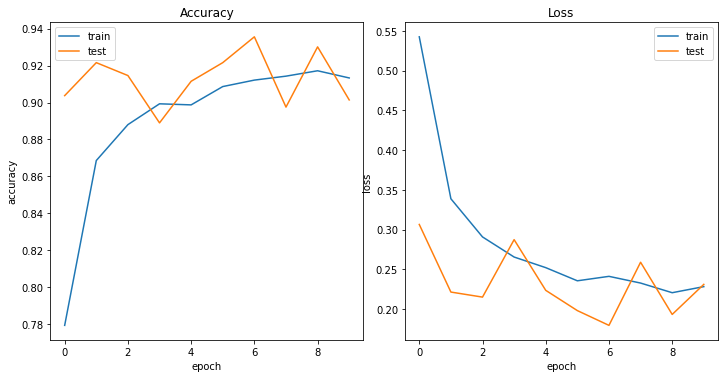

In [26]:
report_plt(hist)

##### Momentum = 0.99

In [27]:
input = layers.Input(shape=(80,80,1))
out = layers.Flatten()(input)
out = layers.Dense(1024, activation=activations.relu)(out)
out = layers.Dense(1024, activation=activations.relu)(out)
out = layers.Dense(3, activation=activations.softmax)(out)
model = models.Model(inputs=input, outputs=out)
model.compile(optimizer=optimizers.SGD(learning_rate=0.01, momentum=0.99), loss=losses.categorical_crossentropy, metrics=["accuracy"])
hist = model.fit(dataTrain, validation_data=dataTest, epochs=10)

Epoch 1/10
161/161 [==============================] - 149s 924ms/step - loss: 0.8635 - accuracy: 0.6803 - val_loss: 0.2087 - val_accuracy: 0.9185
Epoch 2/10
161/161 [==============================] - 144s 897ms/step - loss: 0.5083 - accuracy: 0.8391 - val_loss: 0.8421 - val_accuracy: 0.6778
Epoch 3/10
161/161 [==============================] - 143s 890ms/step - loss: 0.7737 - accuracy: 0.7382 - val_loss: 0.4889 - val_accuracy: 0.8595
Epoch 4/10
161/161 [==============================] - 143s 890ms/step - loss: 0.5764 - accuracy: 0.8159 - val_loss: 0.8424 - val_accuracy: 0.6638
Epoch 5/10
161/161 [==============================] - 143s 888ms/step - loss: 0.8227 - accuracy: 0.6701 - val_loss: 0.8533 - val_accuracy: 0.6638
Epoch 6/10
161/161 [==============================] - 143s 888ms/step - loss: 0.8411 - accuracy: 0.6687 - val_loss: 0.8387 - val_accuracy: 0.6638
Epoch 7/10
161/161 [==============================] - 143s 892ms/step - loss: 0.8360 - accuracy: 0.6646 - val_loss: 0.8402 -

In [28]:
report(model, no_shuffle_dataTrain, no_shuffle_dataTest)

TRAIN
              precision    recall  f1-score   support

       Covid       0.00      0.00      0.00       460
      Normal       0.00      0.00      0.00      1266
   Pneumonia       0.66      1.00      0.80      3418

    accuracy                           0.66      5144
   macro avg       0.22      0.33      0.27      5144
weighted avg       0.44      0.66      0.53      5144



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TEST
              precision    recall  f1-score   support

       Covid       0.00      0.00      0.00       116
      Normal       0.00      0.00      0.00       317
   Pneumonia       0.66      1.00      0.80       855

    accuracy                           0.66      1288
   macro avg       0.22      0.33      0.27      1288
weighted avg       0.44      0.66      0.53      1288



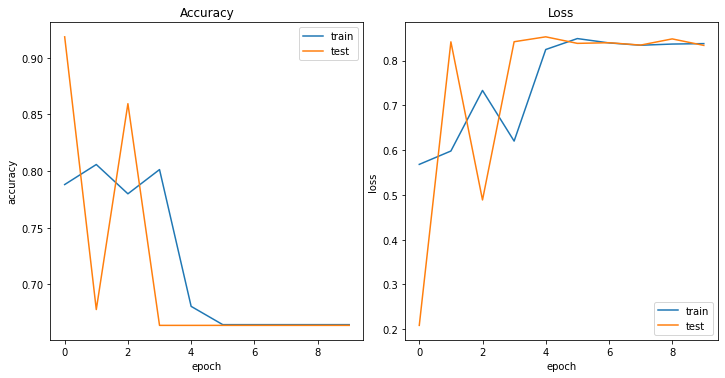

In [29]:
report_plt(hist)

As we can observer in the previous outputs, When momentum gets high It misses the optimal values.  
For example from the physics prespective when a ball gets down the hill with lots of acceleration it misses the point.  
Really low momentum values are prone to not learning and getting stuck in the local minima. 

Choosing a really high value for the momentum term is not always a good choice, because it may miss the minimum.  
Maybe one good choice is to start with little momentum values and then gradually add to the momentum value.  

#### Adam

Adam is a newly presented optimization method by Diederik Kingma and Jimmy Ba.  
The simple form can be shown as below:  
m = beta1*m + (1-beta1)*dx  
v = beta2*v + (1-beta2)*(dx**2)  
x += - learning_rate * m / (np.sqrt(v) + eps)  

Source: __Cs231n stanford university__

In [9]:
input = layers.Input(shape=(80,80,1))
out = layers.Flatten()(input)
out = layers.Dense(1024, activation=activations.relu)(out)
out = layers.Dense(1024, activation=activations.relu)(out)
out = layers.Dense(3, activation=activations.softmax)(out)
model = models.Model(inputs=input, outputs=out)
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss=losses.categorical_crossentropy, metrics=["accuracy"])
hist = model.fit(dataTrain, validation_data=dataTest, epochs=10)

Epoch 1/10
161/161 [==============================] - 170s 1s/step - loss: 2.1481 - accuracy: 0.6965 - val_loss: 0.5615 - val_accuracy: 0.7453
Epoch 2/10
161/161 [==============================] - 169s 1s/step - loss: 0.3587 - accuracy: 0.8499 - val_loss: 0.2089 - val_accuracy: 0.9270
Epoch 3/10
161/161 [==============================] - 169s 1s/step - loss: 0.3280 - accuracy: 0.8693 - val_loss: 0.2072 - val_accuracy: 0.9270
Epoch 4/10
161/161 [==============================] - 169s 1s/step - loss: 0.2747 - accuracy: 0.8988 - val_loss: 0.2641 - val_accuracy: 0.8983
Epoch 5/10
161/161 [==============================] - 169s 1s/step - loss: 0.2561 - accuracy: 0.9052 - val_loss: 0.2303 - val_accuracy: 0.9130
Epoch 6/10
161/161 [==============================] - 168s 1s/step - loss: 0.2645 - accuracy: 0.9023 - val_loss: 0.1954 - val_accuracy: 0.9293
Epoch 7/10
161/161 [==============================] - 169s 1s/step - loss: 0.2556 - accuracy: 0.9062 - val_loss: 0.1883 - val_accuracy: 0.9371

In [14]:
report(model, no_shuffle_dataTrain, no_shuffle_dataTest)

TRAIN
              precision    recall  f1-score   support

       Covid       0.96      0.83      0.89       460
      Normal       0.81      0.94      0.87      1266
   Pneumonia       0.96      0.92      0.94      3418

    accuracy                           0.92      5144
   macro avg       0.91      0.90      0.90      5144
weighted avg       0.93      0.92      0.92      5144

TEST
              precision    recall  f1-score   support

       Covid       0.98      0.83      0.90       116
      Normal       0.82      0.95      0.88       317
   Pneumonia       0.96      0.93      0.95       855

    accuracy                           0.92      1288
   macro avg       0.92      0.90      0.91      1288
weighted avg       0.93      0.92      0.93      1288



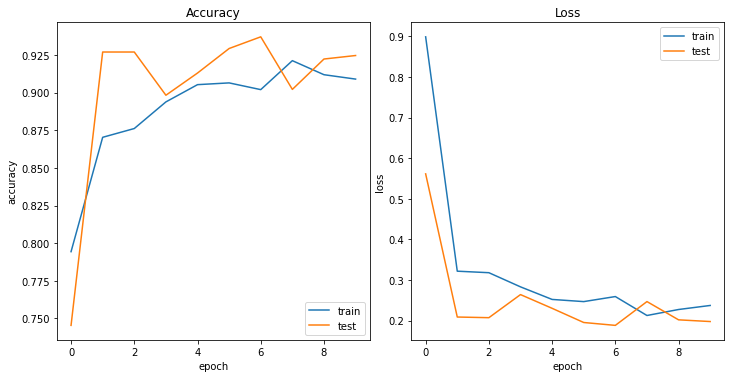

In [15]:
report_plt(hist)

It is shown that Adam can miss the optimal solution and work poorly in comparison to sgd.  
But it is faster than the sgd algorithm.

### Epochs

The reason for training the model on multiple epochs is first that we may not have __enough data.__  
And the second reason is that we need to train on multiple epochs to learn the parameters better and have a better accuracy.

Not always using lots of epochs is good, because there is the danger of __overfitting.__  
Overfitting is dangerous because it learns the noise in our data and it will not be able to generalize well in the real world.  
So the common approach is to start the training and __early stop__ it when we observe overfitting.  
We can check overfitting by comparing the validation metrics.  
There are other approaches such as regularization methods to tackle overfitting challenge.

In [16]:
input = layers.Input(shape=(80,80,1))
out = layers.Flatten()(input)
out = layers.Dense(1024, activation=activations.relu)(out)
out = layers.Dense(1024, activation=activations.relu)(out)
out = layers.Dense(3, activation=activations.softmax)(out)
model = models.Model(inputs=input, outputs=out)
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss=losses.categorical_crossentropy, metrics=["accuracy"])
hist = model.fit(dataTrain, validation_data=dataTest, epochs=20)

Epoch 1/20
161/161 [==============================] - 169s 1s/step - loss: 2.2395 - accuracy: 0.6812 - val_loss: 0.2651 - val_accuracy: 0.8983
Epoch 2/20
161/161 [==============================] - 168s 1s/step - loss: 0.3181 - accuracy: 0.8807 - val_loss: 0.2284 - val_accuracy: 0.9216
Epoch 3/20
161/161 [==============================] - 167s 1s/step - loss: 0.2824 - accuracy: 0.8945 - val_loss: 0.2160 - val_accuracy: 0.9208
Epoch 4/20
161/161 [==============================] - 167s 1s/step - loss: 0.2609 - accuracy: 0.8996 - val_loss: 0.1988 - val_accuracy: 0.9239
Epoch 5/20
161/161 [==============================] - 168s 1s/step - loss: 0.2578 - accuracy: 0.9001 - val_loss: 0.1708 - val_accuracy: 0.9379
Epoch 6/20
161/161 [==============================] - 167s 1s/step - loss: 0.2416 - accuracy: 0.9052 - val_loss: 0.2546 - val_accuracy: 0.9045
Epoch 7/20
161/161 [==============================] - 168s 1s/step - loss: 0.2428 - accuracy: 0.9112 - val_loss: 0.2422 - val_accuracy: 0.9293

In [17]:
report(model, no_shuffle_dataTrain, no_shuffle_dataTest)

TRAIN
              precision    recall  f1-score   support

       Covid       0.97      0.78      0.87       460
      Normal       0.89      0.91      0.90      1266
   Pneumonia       0.94      0.96      0.95      3418

    accuracy                           0.93      5144
   macro avg       0.93      0.88      0.91      5144
weighted avg       0.93      0.93      0.93      5144

TEST
              precision    recall  f1-score   support

       Covid       1.00      0.73      0.85       116
      Normal       0.88      0.94      0.91       317
   Pneumonia       0.94      0.96      0.95       855

    accuracy                           0.93      1288
   macro avg       0.94      0.88      0.90      1288
weighted avg       0.93      0.93      0.93      1288



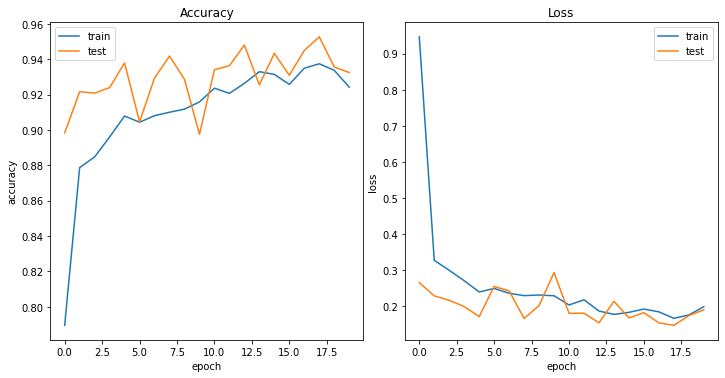

In [18]:
report_plt(hist)

### Losses

#### MSE

As we can see it works worse in comparison to the categorical cross entropy,  
And it does not learn well.  

Using MSE for classification is not a good choice because,  
It assumes that the data has a guassian distribution and this may not be true.  
The next reason is that it is not convex and it may get stuck in places and don't catch the global minumum.  
MSE is more commonly used in __Regression problems__.

In [19]:
input = layers.Input(shape=(80,80,1))
out = layers.Flatten()(input)
out = layers.Dense(1024, activation=activations.relu)(out)
out = layers.Dense(1024, activation=activations.relu)(out)
out = layers.Dense(3, activation=activations.softmax)(out)
model = models.Model(inputs=input, outputs=out)
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss="mean_squared_error", metrics=["accuracy"])
hist = model.fit(dataTrain, validation_data=dataTest, epochs=20)

Epoch 1/20
161/161 [==============================] - 167s 1s/step - loss: 0.4919 - accuracy: 0.2575 - val_loss: 0.5026 - val_accuracy: 0.2461
Epoch 2/20
161/161 [==============================] - 165s 1s/step - loss: 0.5081 - accuracy: 0.2379 - val_loss: 0.5026 - val_accuracy: 0.2461
Epoch 3/20
161/161 [==============================] - 166s 1s/step - loss: 0.5035 - accuracy: 0.2448 - val_loss: 0.5026 - val_accuracy: 0.2461
Epoch 4/20
161/161 [==============================] - 167s 1s/step - loss: 0.5059 - accuracy: 0.2412 - val_loss: 0.5026 - val_accuracy: 0.2461
Epoch 5/20
161/161 [==============================] - 167s 1s/step - loss: 0.5092 - accuracy: 0.2362 - val_loss: 0.5026 - val_accuracy: 0.2461
Epoch 6/20
161/161 [==============================] - 170s 1s/step - loss: 0.4984 - accuracy: 0.2523 - val_loss: 0.5026 - val_accuracy: 0.2461
Epoch 7/20
161/161 [==============================] - 171s 1s/step - loss: 0.5093 - accuracy: 0.2361 - val_loss: 0.5026 - val_accuracy: 0.2461

In [20]:
report(model, no_shuffle_dataTrain, no_shuffle_dataTest)

TRAIN
              precision    recall  f1-score   support

       Covid       0.00      0.00      0.00       460
      Normal       0.25      1.00      0.40      1266
   Pneumonia       0.00      0.00      0.00      3418

    accuracy                           0.25      5144
   macro avg       0.08      0.33      0.13      5144
weighted avg       0.06      0.25      0.10      5144



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TEST
              precision    recall  f1-score   support

       Covid       0.00      0.00      0.00       116
      Normal       0.25      1.00      0.40       317
   Pneumonia       0.00      0.00      0.00       855

    accuracy                           0.25      1288
   macro avg       0.08      0.33      0.13      1288
weighted avg       0.06      0.25      0.10      1288



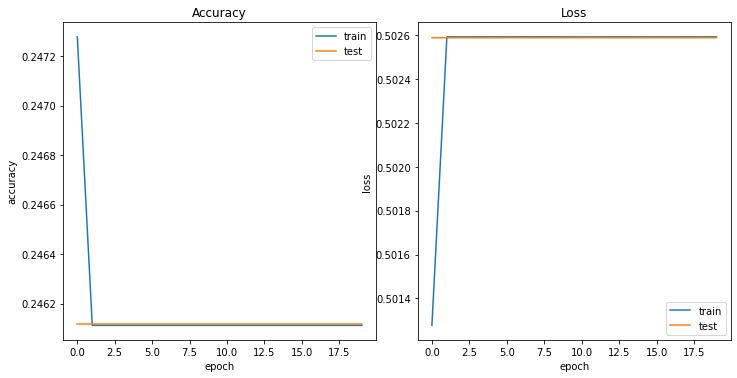

In [21]:
report_plt(hist)

### Regularization
As we mentioned earlier regularization helps preventing overfitting our data.

#### L2
In this approach we have the term (0.5)*λ*w^2 and it helps us to control the weights.  
It means that it does not let them to grow a lot. It helps us keep the weights small and prevent overfitting.  
We can observer this in the output as well.

In [22]:
input = layers.Input(shape=(80,80,1))
out = layers.Flatten()(input)
out = layers.Dense(1024, activation=activations.relu, kernel_regularizer=regularizers.l2(0.0001))(out)
out = layers.Dense(1024, activation=activations.relu, kernel_regularizer=regularizers.l2(0.0001))(out)
out = layers.Dense(3, activation=activations.softmax, kernel_regularizer=regularizers.l2(0.0001))(out)
model = models.Model(inputs=input, outputs=out)
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss=losses.categorical_crossentropy, metrics=["accuracy"])
hist = model.fit(dataTrain, validation_data=dataTest, epochs=20)

Epoch 1/20
161/161 [==============================] - 172s 1s/step - loss: 1.8849 - accuracy: 0.6804 - val_loss: 0.4298 - val_accuracy: 0.8944
Epoch 2/20
161/161 [==============================] - 168s 1s/step - loss: 0.4521 - accuracy: 0.8818 - val_loss: 0.3505 - val_accuracy: 0.9231
Epoch 3/20
161/161 [==============================] - 172s 1s/step - loss: 0.4367 - accuracy: 0.8799 - val_loss: 0.3157 - val_accuracy: 0.9317
Epoch 4/20
161/161 [==============================] - 172s 1s/step - loss: 0.3903 - accuracy: 0.8971 - val_loss: 0.3639 - val_accuracy: 0.8975
Epoch 5/20
161/161 [==============================] - 172s 1s/step - loss: 0.3721 - accuracy: 0.8941 - val_loss: 0.2888 - val_accuracy: 0.9278
Epoch 6/20
161/161 [==============================] - 169s 1s/step - loss: 0.3538 - accuracy: 0.9009 - val_loss: 0.2711 - val_accuracy: 0.9286
Epoch 7/20
161/161 [==============================] - 167s 1s/step - loss: 0.3255 - accuracy: 0.9099 - val_loss: 0.2520 - val_accuracy: 0.9356

In [23]:
report(model, no_shuffle_dataTrain, no_shuffle_dataTest)

TRAIN
              precision    recall  f1-score   support

       Covid       0.95      0.94      0.94       460
      Normal       0.90      0.92      0.91      1266
   Pneumonia       0.97      0.96      0.97      3418

    accuracy                           0.95      5144
   macro avg       0.94      0.94      0.94      5144
weighted avg       0.95      0.95      0.95      5144

TEST
              precision    recall  f1-score   support

       Covid       0.90      0.90      0.90       116
      Normal       0.89      0.93      0.91       317
   Pneumonia       0.97      0.95      0.96       855

    accuracy                           0.94      1288
   macro avg       0.92      0.93      0.92      1288
weighted avg       0.94      0.94      0.94      1288



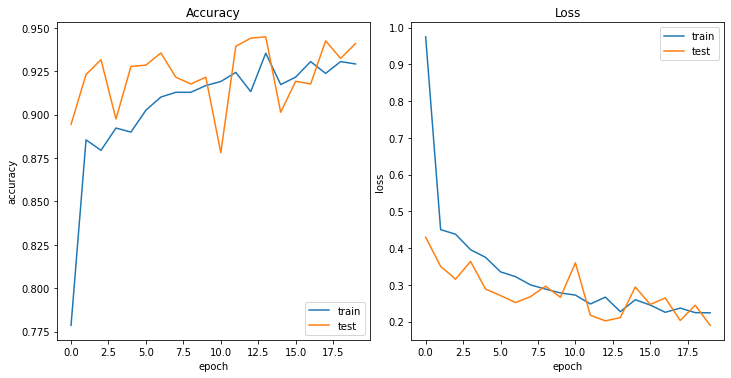

In [24]:
report_plt(hist)

#### Drop out

In this approach we drop some neurons with respect to a probability and it helps us prevent overfitting.  
We will learn just some values in each part and it helps generalizing better.  
We can see the following observation in the output as well.  
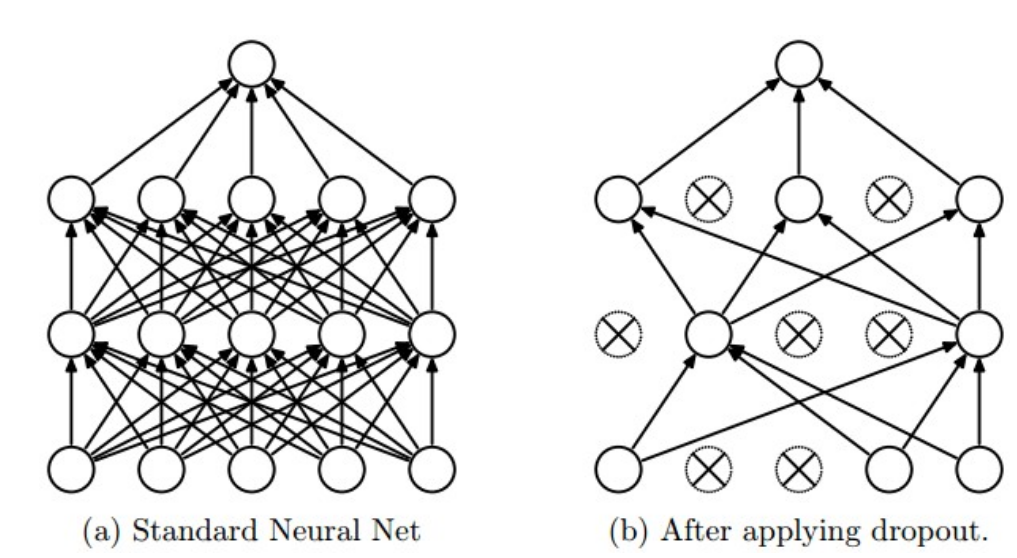  
Source: __Cs231n Stanford University__

In [25]:
input = layers.Input(shape=(80,80,1))
out = layers.Flatten()(input)
out = layers.Dense(1024, activation=activations.relu)(out)
out = layers.Dropout(rate=0.1)(out)
out = layers.Dense(1024, activation=activations.relu)(out)
out = layers.Dropout(rate=0.1)(out)
out = layers.Dense(3, activation=activations.softmax)(out)
model = models.Model(inputs=input, outputs=out)
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss=losses.categorical_crossentropy, metrics=["accuracy"])
hist = model.fit(dataTrain, validation_data=dataTest, epochs=20)

Epoch 1/20
161/161 [==============================] - 168s 1s/step - loss: 2.6540 - accuracy: 0.6564 - val_loss: 0.4276 - val_accuracy: 0.8276
Epoch 2/20
161/161 [==============================] - 166s 1s/step - loss: 0.3676 - accuracy: 0.8598 - val_loss: 0.3945 - val_accuracy: 0.8447
Epoch 3/20
161/161 [==============================] - 168s 1s/step - loss: 0.3510 - accuracy: 0.8691 - val_loss: 0.1940 - val_accuracy: 0.9270
Epoch 4/20
161/161 [==============================] - 167s 1s/step - loss: 0.3046 - accuracy: 0.8808 - val_loss: 0.1875 - val_accuracy: 0.9317
Epoch 5/20
161/161 [==============================] - 166s 1s/step - loss: 0.2815 - accuracy: 0.8957 - val_loss: 0.4348 - val_accuracy: 0.8230
Epoch 6/20
161/161 [==============================] - 169s 1s/step - loss: 0.2741 - accuracy: 0.8982 - val_loss: 0.2773 - val_accuracy: 0.8766
Epoch 7/20
161/161 [==============================] - 167s 1s/step - loss: 0.2505 - accuracy: 0.9071 - val_loss: 0.2468 - val_accuracy: 0.9107

In [26]:
report(model, no_shuffle_dataTrain, no_shuffle_dataTest)

TRAIN
              precision    recall  f1-score   support

       Covid       0.97      0.85      0.90       460
      Normal       0.89      0.91      0.90      1266
   Pneumonia       0.95      0.96      0.96      3418

    accuracy                           0.94      5144
   macro avg       0.94      0.91      0.92      5144
weighted avg       0.94      0.94      0.94      5144

TEST
              precision    recall  f1-score   support

       Covid       0.98      0.80      0.88       116
      Normal       0.88      0.92      0.90       317
   Pneumonia       0.96      0.96      0.96       855

    accuracy                           0.94      1288
   macro avg       0.94      0.90      0.91      1288
weighted avg       0.94      0.94      0.94      1288



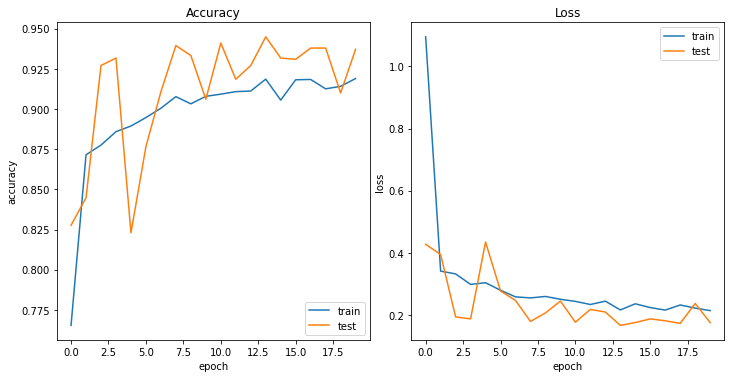

In [27]:
report_plt(hist)